In [31]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper", font_scale=3)

# df = pd.read_pickle("df.pickle")
# df

df_1 = pd.read_pickle("lightning_logs/version_918/checkpoints/epoch=99-val_acc=0.00_results.pickle")
pd.DataFrame.from_records(df_1)

,message_lengths/dataloader_idx_0,receiver_loss/dataloader_idx_0,entropy_loss/dataloader_idx_0,policy_loss/dataloader_idx_0,policy_length_loss/dataloader_idx_0,val_acc,val_acc_no_noise,best_val_acc_no_noise,test_acc,test_acc_no_noise,...,message_lengths/dataloader_idx_1,receiver_loss/dataloader_idx_1,entropy_loss/dataloader_idx_1,policy_loss/dataloader_idx_1,policy_length_loss/dataloader_idx_1,message_lengths/dataloader_idx_2,receiver_loss/dataloader_idx_2,entropy_loss/dataloader_idx_2,policy_loss/dataloader_idx_2,policy_length_loss/dataloader_idx_2
0,5.086957,1.378969,1.378561,-37.400921,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,5.923077,1.377326,1.379277,-42.418217,0.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,5.144928,1.364818,1.378319,-37.195118,0.0


In [29]:
REFERENCE_METRIC = "val_acc_no_noise"

indices_best_steps = df.groupby(df.index)[REFERENCE_METRIC].idxmax()

df = df.loc[list(indices_best_steps)]
df

,step,best_val_acc,bosdis,bosdis_at_best_val_acc,entropy_loss,entropy_loss/dataloader_idx_0,entropy_loss/dataloader_idx_1,entropy_loss/dataloader_idx_2,epoch,hp_metric,...,sync_batchnorm,terminate_on_nan,test_set_size,tpu_cores,track_grad_norm,val_check_interval,vocab_size,vocab_size_feedback,weights_save_path,weights_summary
dir_name,,,,,,,,,,,,,,,,,,,,,
version_897,99,0.000000,0.042690,NaN,1.380523,1.379918,1.379937,1.380110,99.0,NaN,...,0.0,None,0.1,None,-1.0,None,100.0,2.0,None,top
version_898,1899,0.956522,0.075761,0.075761,1.035066,1.059727,1.061419,1.065278,1899.0,NaN,...,0.0,None,0.1,None,-1.0,None,100.0,2.0,None,top
version_900,2399,0.826087,0.069380,0.069380,1.037340,1.037599,1.058600,1.066302,2399.0,NaN,...,0.0,None,0.1,None,-1.0,None,100.0,2.0,None,top
version_901,99,0.043478,0.033126,0.033126,1.379904,1.377936,1.377953,1.378216,99.0,NaN,...,0.0,None,0.1,None,-1.0,None,100.0,2.0,None,top


In [16]:
MAX_N_RUNS = 10
df.dropna(subset=["num_attributes", "num_values"], inplace=True)

assert (df.sender_entropy_coeff == df.receiver_entropy_coeff).all()
assert (df.num_senders == df.num_receivers).all()

df["entropy_coeff"] = df["sender_entropy_coeff"]
df["num_agents"] = df["num_senders"]

runs_best_entropy = []

df["attr_val"] = df["num_attributes"].map(int).map(str) + "_" + df["num_values"].map(int).map(str)
attr_val_combinations = df["attr_val"].unique()

num_agents_values = df["num_agents"].unique()
for num_agents in num_agents_values:
    print(f"\nNum agents: {num_agents}")

    for attr_val in attr_val_combinations:
        n_attributes = int(float(attr_val.split("_")[0]))
        n_values = int(float(attr_val.split("_")[1]))
        print(f"\n\t\tAttr: {n_attributes} Values: {n_values}")

        # length_cost_values = df["length_cost"].unique()
        length_cost_values = [0, 0.001]
        for length_cost in length_cost_values:

            max_len_values = df.max_len.unique()
            for max_len in max_len_values:

                noise_values = df.noise.unique()
                for noise in noise_values:
                    for feedback in (0, 1):
                        for self_repair in (0, 1):

                            df_config = df[(df.attr_val == attr_val) & (df.length_cost == length_cost) & (df.feedback == feedback) & (df.num_agents == num_agents) & (df.noise == noise) & (df.self_repair == self_repair) & (df.max_len == max_len)]

                            if len(df_config) == 0:
                                continue

                            print(f"\t\t\tLength cost: {length_cost}\t Noise: {noise}", end="")

                            if feedback:
                                print("\tFeedback", end="")
                            elif self_repair:
                                print("\tSelf repair", end="")
                            else:
                                print("\tBaseline", end="")

                            print(f"\tFound {len(df_config)} runs") #: {df_config}

                            avg_val_accs = df_config.groupby("sender_entropy_coeff").aggregate({"best_val_acc": "mean"})
                            # Take the highest entropy coeff in case of tie
                            best_entropy_coeff = avg_val_accs[avg_val_accs.best_val_acc == avg_val_accs.max()[0]].index[-1]

                            df_best_entropy = df_config[df_config.entropy_coeff == best_entropy_coeff]
                            print(f"\t\t\t\t\t\tbest entropy coeff: {best_entropy_coeff}; num runs: {len(df_best_entropy)}", end="")
                            print(f"\tother: {avg_val_accs.to_dict()})", )

                            if len(df_best_entropy) > MAX_N_RUNS:
                                df_best_entropy = df_best_entropy.tail(10)
                            runs_best_entropy.append(df_best_entropy)

data = pd.concat(runs_best_entropy, ignore_index=True)





Num agents: 1.0

		Attr: 4 Values: 4
			Length cost: 0	 Noise: 0.0	Baseline	Found 15 runs
						best entropy coeff: 0.3; num runs: 5	other: {'best_val_acc': {0.1: 0.8869565248489379, 0.3: 0.895652174949646, 0.5: 0.747826087474823}})
			Length cost: 0	 Noise: 0.1	Baseline	Found 15 runs
						best entropy coeff: 0.1; num runs: 5	other: {'best_val_acc': {0.1: 0.834782600402832, 0.3: 0.8, 0.5: 0.6869565129280091}})
			Length cost: 0	 Noise: 0.1	Self repair	Found 15 runs
						best entropy coeff: 0.1; num runs: 5	other: {'best_val_acc': {0.1: 0.852173900604248, 0.3: 0.808695650100708, 0.5: 0.7130434811115265}})
			Length cost: 0	 Noise: 0.1	Feedback	Found 15 runs
						best entropy coeff: 0.1; num runs: 5	other: {'best_val_acc': {0.1: 0.799999988079071, 0.3: 0.704347825050354, 0.5: 0.713043475151062}})


In [13]:
def calc_capacity(row):
    return math.pow(row.num_values, row.num_attributes)

data["capacity"] = data.apply(calc_capacity, axis=1)
data.sort_values("capacity", inplace=True)

/home/mitja/anaconda3/envs/emergent_communication/lib/python3.9/site-packages/seaborn/categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/mitja/anaconda3/envs/emergent_communication/lib/python3.9/site-packages/seaborn/categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/mitja/anaconda3/envs/emergent_communication/lib/python3.9/site-packages/seaborn/categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/mitja/anaconda3/envs/emergent_communication/lib/python3.9/site-packages/seaborn/categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar

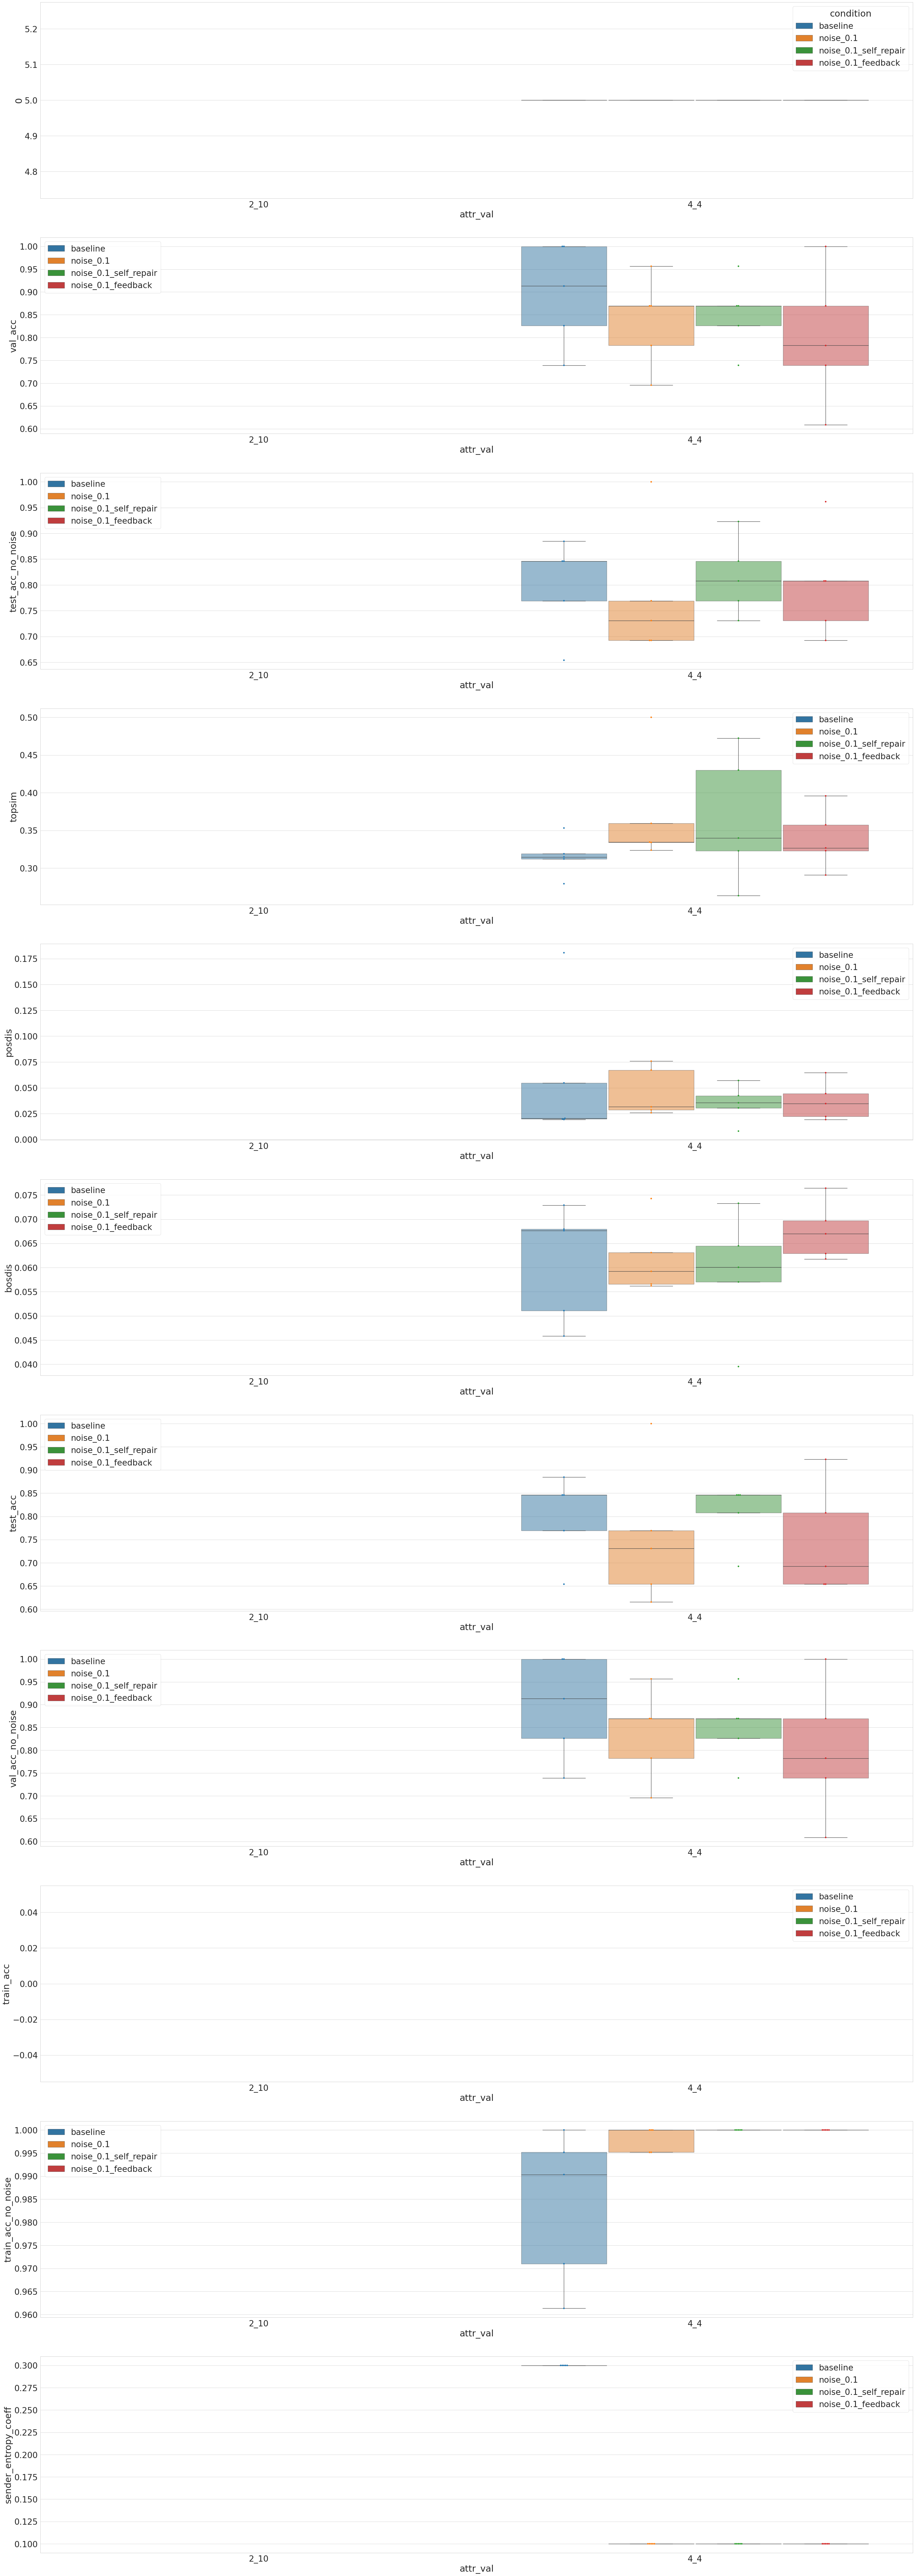

In [17]:
data["condition"] = data["noise"].map(lambda x: f"noise_{x}" if x > 0 else "baseline") + data["length_cost"].map(lambda x: f"_length_cost_{x}" if x > 0 else "") + data["feedback"].map(lambda x: "_feedback" if x else "") + data["self_repair"].map(lambda x: "_self_repair" if x else "")

# Exclude bad noise setting
target_data = data[~(data.noise == 0.3)]

# TODO: num_agents setting
NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 5
target_data = target_data[target_data.max_len == MAX_LEN]

# ATTR_VAL = "4_5"
# target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

# print(target_data.dir_name.unique())

# hue_order = None
# hue_order = ["baseline", "noise_0.1", "noise_0.1_feedback_binary"]
hue_order = ["baseline", "noise_0.1", "noise_0.1_self_repair", "noise_0.1_feedback"]

# order = ["2_10", "3_5", "2_16", "4_4", "4_5", "3_10", "2_100"]
order = ["2_10", "4_4"]


target_hparam = "attr_val"

num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()
# plt.figure(figsize=(30, 10))

_, axes = plt.subplots(11, 1, figsize=(50, 150))

sns.boxplot(ax=axes[0], data=num_runs_data, x="attr_val", order=order, hue="condition", hue_order=hue_order, y=0)

# next_axis_idx = (0, 0)
for i, metric in enumerate(["val_acc", "test_acc_no_noise", "topsim", "posdis", "bosdis", "test_acc", "val_acc_no_noise", "train_acc", "train_acc_no_noise", "sender_entropy_coeff"]):
    sns.boxplot(ax=axes[i+1], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, boxprops=dict(alpha=.5), showfliers = False)
    ax = sns.swarmplot(ax=axes[i+1], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, dodge=True)
    handles, labels = ax.get_legend_handles_labels()
    num_conditions = int(len(handles)/2) if not hue_order else len(hue_order)
    ax.legend(handles[:num_conditions], labels[:num_conditions])
    # plt.setp(ax.get_legend().get_texts(), fontsize='22')
    # if next_axis_idx[1] >= axes.shape[1]-1:
    #     next_axis_idx = (next_axis_idx[0]+1, 0)
    # else:
    #     next_axis_idx = (next_axis_idx[0], next_axis_idx[1]+1)

name = "results"
plt.savefig("plots/"+name+".pdf", dpi=300)

/home/mitja/anaconda3/envs/emergent_communication/lib/python3.9/site-packages/seaborn/categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/mitja/anaconda3/envs/emergent_communication/lib/python3.9/site-packages/seaborn/categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/mitja/anaconda3/envs/emergent_communication/lib/python3.9/site-packages/seaborn/categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/mitja/anaconda3/envs/emergent_communication/lib/python3.9/site-packages/seaborn/categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar

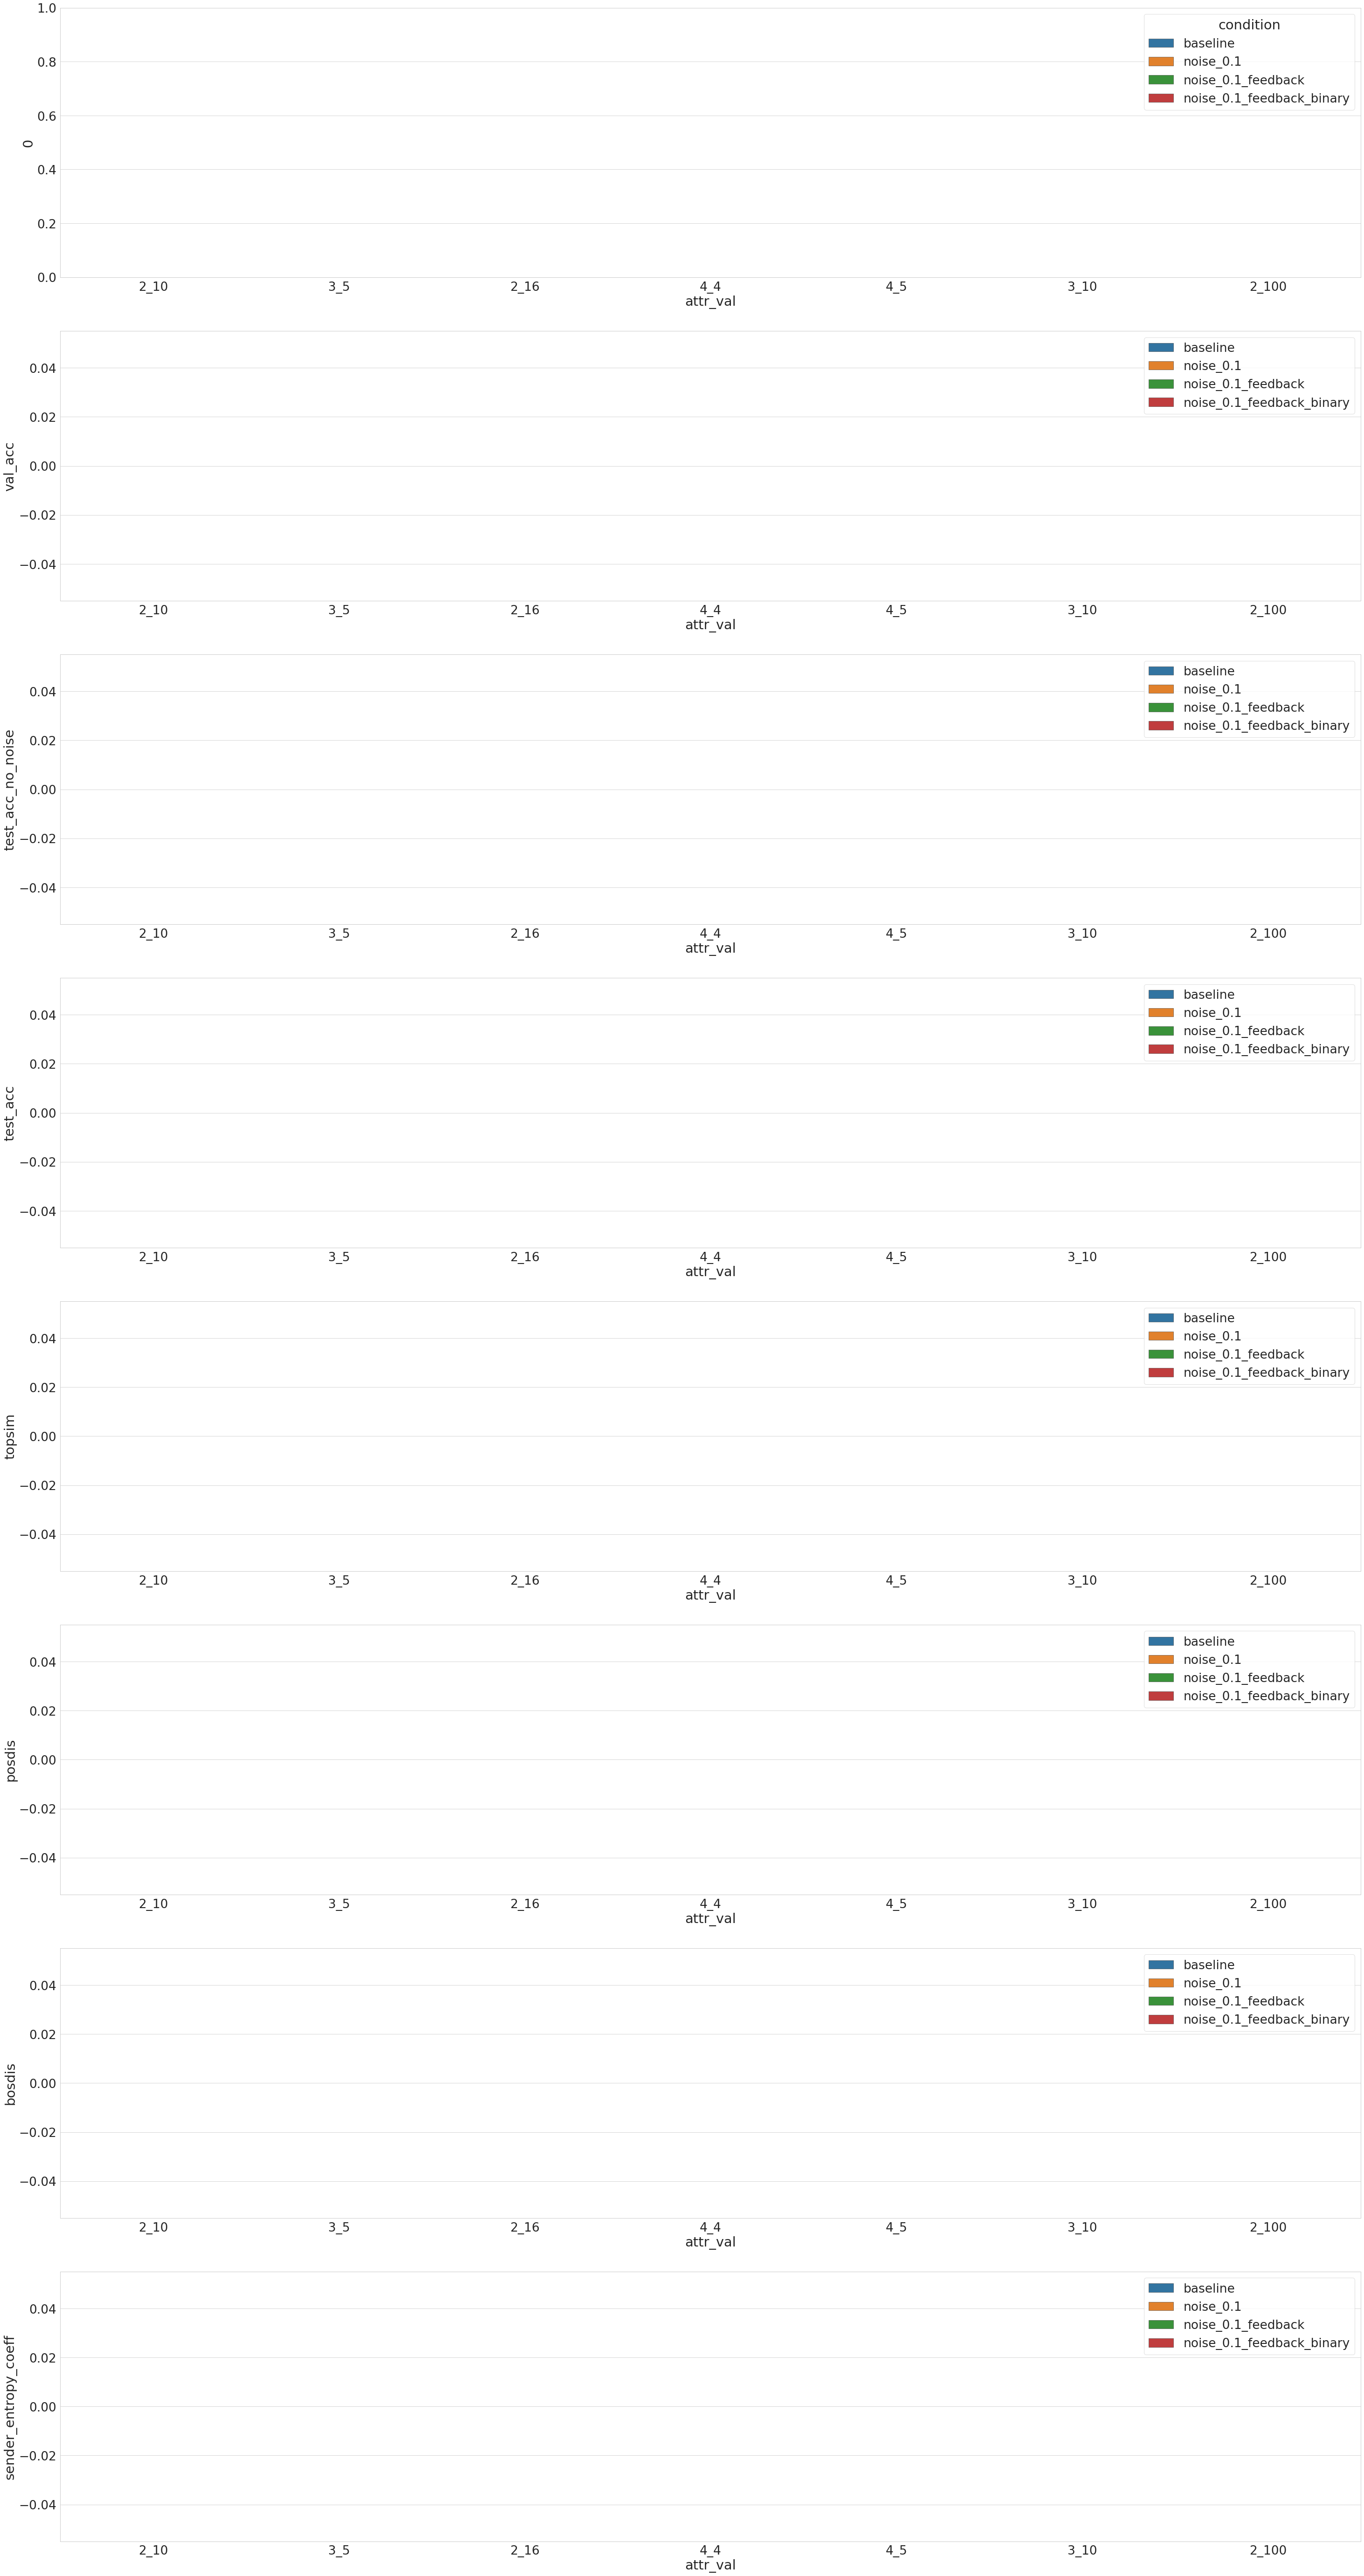

In [15]:
data["condition"] = data["noise"].map(lambda x: f"noise_{x}" if x > 0 else "baseline") + data["length_cost"].map(lambda x: f"_length_cost_{x}" if x > 0 else "") + data["feedback"].map(lambda x: "_feedback" if x else "") + data["self_repair"].map(lambda x: "_binary" if x else "") #+ data["num_agents"].map(lambda x: "_2_agents" if x else "")

# Exclude bad noise setting
target_data = data[~(data.noise == 0.3)]

# TODO: open CR setting
# target_data = target_data[target_data.self_repair == 0]

# TODO: num_agents setting
NUM_AGENTS = 2
target_data = target_data[target_data.num_agents == NUM_AGENTS]


ATTR_VAL = "4_4"
target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

# print(target_data.dir_name.unique())

# hue_order = None
# hue_order = ["baseline", "noise_0.1", "noise_0.1_length_cost_0.001", "noise_0.1_length_cost_0.001_feedback"]
# hue_order = ["baseline", "noise_0.1", "noise_0.1_feedback_binary"]#, , "noise_0.1_length_cost_0.001_feedback","noise_0.1_length_cost_0.001_feedback"]#, "noise_0.1_length_cost_0.01_feedback"]
hue_order = ["baseline", "noise_0.1", "noise_0.1_feedback", "noise_0.1_feedback_binary"]

order = ["2_10", "3_5", "2_16", "4_4", "4_5", "3_10", "2_100"]

target_hparam = "attr_val"

num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()
# plt.figure(figsize=(30, 10))

_, axes = plt.subplots(8, 1, figsize=(50, 100))

sns.boxplot(ax=axes[0], data=num_runs_data, x="attr_val", order=order, hue="condition", hue_order=hue_order, y=0)

# next_axis_idx = (0, 0)
for i, metric in enumerate(["val_acc", "test_acc_no_noise", "test_acc", "topsim", "posdis", "bosdis", "sender_entropy_coeff"]):
    sns.boxplot(ax=axes[i+1], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, boxprops=dict(alpha=.5), showfliers = False)
    ax = sns.swarmplot(ax=axes[i+1], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, dodge=True)
    handles, labels = ax.get_legend_handles_labels()
    num_conditions = int(len(handles)/2) if not hue_order else len(hue_order)
    ax.legend(handles[:num_conditions], labels[:num_conditions])
    # plt.setp(ax.get_legend().get_texts(), fontsize='22')
    # if next_axis_idx[1] >= axes.shape[1]-1:
    #     next_axis_idx = (next_axis_idx[0]+1, 0)
    # else:
    #     next_axis_idx = (next_axis_idx[0], next_axis_idx[1]+1)

name = "results"
plt.savefig("plots/"+name+".pdf", dpi=300)